Importing necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

Graphical Representation of The Path that is created

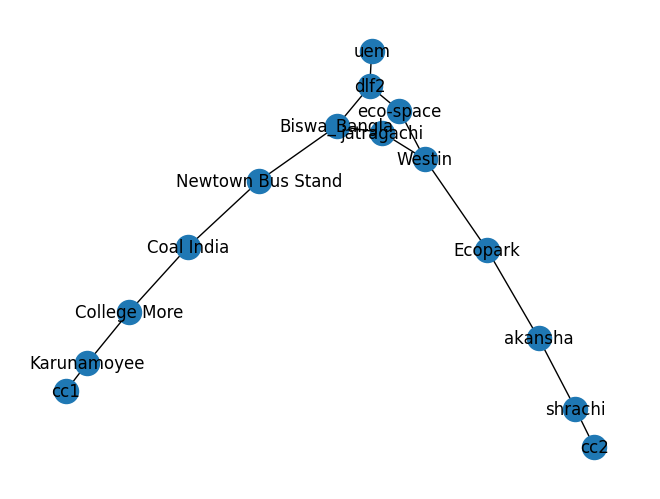

In [2]:
df=pd.read_csv('./path.csv')
location=df['location']
loc_labels={}
i=0
for n in location:
    loc_labels[i]=n
    i=i+1
df = df.drop('location', axis=1)
matrix=df.values.tolist()
matrix=np.array(matrix)

#showing the path in the form of graph
G=nx.from_numpy_array(matrix)
nx.draw_spectral(G, labels=loc_labels,with_labels=True)
#nx.draw_spectral(G,with_labels=True)
plt.show()
#loc_labels

Creating an Adjacency list for better navigation

In [3]:
import pandas as pd

route_path=pd.read_csv('./path.csv')
locations=route_path['location'].to_list()

#Creating an Adjacency List
adjacency_list={}
for l in locations:
    data=route_path[l].to_list()
    empty_list=[]
    for i in range(len(data)):
        if data[i]==1:
            empty_list.append(locations[i])
    adjacency_list[l]=empty_list
adjacency_list

{'akansha': ['Ecopark', 'shrachi'],
 'Biswa_Bangla': ['dlf2', 'jatragachi', 'Newtown Bus Stand'],
 'cc1': ['Karunamoyee'],
 'cc2': ['shrachi'],
 'Coal India': ['College More', 'Newtown Bus Stand'],
 'College More': ['Coal India', 'Karunamoyee'],
 'dlf2': ['Biswa_Bangla', 'eco-space', 'uem'],
 'eco-space': ['dlf2', 'Westin'],
 'Ecopark': ['akansha', 'Westin'],
 'jatragachi': ['Biswa_Bangla', 'Westin'],
 'Karunamoyee': ['cc1', 'College More'],
 'Newtown Bus Stand': ['Biswa_Bangla', 'Coal India'],
 'shrachi': ['akansha', 'cc2'],
 'uem': ['dlf2'],
 'Westin': ['eco-space', 'Ecopark', 'jatragachi']}

Taking the Vehicle no and the Date as input for searching and creating the path the vehicle travelled

In [4]:
#Test Cases

#Test Case - 1
v_no='WB23MW7835'
date='16-10-2023'

#Test Case - 2
#v_no='WB21BD6713'
#date='15-10-2023'

#Test Case - 3
#v_no='WB23YU8191'
#date='12-10-2023'

#v_no='WB48AT6591'
#date='10-11-2023'

date = datetime.strptime(date, "%d-%m-%Y")

Finding the Starting Point where the search of the vehicle will begin

In [5]:
#Function for checking the vehicle is present or not

def check(v,d,loc):
    df = pd.read_csv('./Dataset/' + loc + '.csv')
    for i in range(0, len(df['Vehicle Number'])):
        if df['Vehicle Number'][i] == v and d==datetime.strptime(df['Date'][i], "%d-%m-%Y"):
            return True
    return False

In [6]:
#Function for finding the start point

def find_start(start_id):
    start_node = []
    for key, value in loc_labels.items():
        if value in start_id:
            start_node.append(key)
    bfs=[]

    for node in start_node:
        bfs.append(list(nx.bfs_edges(G, source=node)))

    start=None
    for i in range(0,len(loc_labels)):
        flag=0
        if i==0:
            for j in start_node:
                if check(v_no,date,loc_labels[j]):
                    start=loc_labels[j]
                    flag=1
                    break
        else:
            for j in range(0,len(bfs)):
                if check(v_no,date,loc_labels[bfs[j][i-1][1]]):
                    start=loc_labels[bfs[j][i-1][1]]
                    flag=1
                    break
        if flag==1:
            break
    
    return start        
    

In [7]:
#Calling the function to find the start point

start_points = ['uem', 'cc2', 'cc1']
start=find_start(start_points)

#start

Finding The Path where the Vehicle Travelled

In [8]:
#Function for inserting the route and time in the ascending order

def sort_time(r,t,nr,nt):
    index=None

    for i in range(0,len(t)):
        if datetime.strptime(nt, '%H:%M:%S') < datetime.strptime(t[i], '%H:%M:%S'):
            index=i
            break
    
    if index==None:
        index=len(t)
        
    r.insert(index,nr)
    t.insert(index,nt)
    return r,t

In [9]:
#Function To check the date is greater than previous date

def check_date(pr,date):
    if pr is None:
        return True
    rev = datetime.strptime(pr, "%H:%M:%S").time()
    ow_time = datetime.strptime(date, "%H:%M:%S").time()
    if ow_time>rev:
        return True
    return False

In [10]:
#Function to Find that the Vehicle has taken any U-Turn or Not

def find_Uturn(prev,prev_time):
    df = pd.read_csv('./Dataset/' + prev + '.csv')
    df = df.sort_values(by=['Date', 'Time'], ascending=True)

    for i in range(len(df['Vehicle Number'])):
        if df['Vehicle Number'][i] == v_no and date == datetime.strptime(df['Date'][i], "%d-%m-%Y"):
            if check_date(prev_time,df['Time'][i]):
                return True

    return False

In [11]:
#Function to find the Path travelled by the Vehicle

def path_finder(start,prev,prev_time,v_no,date,adjacency_list,route,time):
    df = pd.read_csv('./Dataset/' + start + '.csv')
    df = df.sort_values(by=['Date', 'Time'], ascending=True)
    for i in range(0, len(df['Vehicle Number'])):
        if df['Vehicle Number'][i] == v_no and date==datetime.strptime(df['Date'][i], "%d-%m-%Y"):
            if check_date(prev_time,df['Time'][i]):
                route.append(start)
                time.append(df['Time'][i])
                break

    while True:
        curr = adjacency_list[start][:]#Important part [:] if not given it will reflect into original
        if prev in curr:
            curr.remove(prev)
        flag = 0
        for cu in curr:
            df = pd.read_csv('./Dataset/' + cu + '.csv')
            df = df.sort_values(by=['Date', 'Time'], ascending=True)
            for i in range(0, len(df['Vehicle Number'])):
                if df['Vehicle Number'][i] == v_no and date==datetime.strptime(df['Date'][i], "%d-%m-%Y"):
                    if check_date(prev_time,df['Time'][i]):
                        route,time=sort_time(route,time,cu,df['Time'][i])
                        prev = start
                        prev_time=df['Time'][i]
                        start = cu
                        flag=1
                        break
        if flag==0:
            break
    return route,time,start,prev,prev_time

In [12]:
prev=None
prev_time=None
route=[]
time=[]

#Finding The Path
route,time,start,prev,prev_time=path_finder(start,prev,prev_time,v_no,date,adjacency_list,route,time)

#Checking The Vehicle is taking a U-Turn or not
if find_Uturn(prev,prev_time):
    t=start
    start=prev
    prev=t
    route,time,_,_,_=path_finder(start,prev,prev_time,v_no,date,adjacency_list,route,time)


Printing the Route

In [13]:
print(route)
print(time)

if len(route)!=0:
    print(f"Route which the vehicle {v_no} had went: ")
    for r in range(len(route)):
        print(route[r],end='')
        if r<len(route)-1:
            print(" -> ",end='')

    start_time = datetime.strptime(time[0], '%H:%M:%S')
    end_time = datetime.strptime(time[len(time)-1], '%H:%M:%S')
    time_difference = end_time - start_time

    print("\nTime taken to reach the destination: ",time_difference)

['akansha', 'Ecopark', 'Westin', 'jatragachi']
['08:12:10', '08:16:10', '08:23:10', '08:28:10']
Route which the vehicle WB23MW7835 had went: 
akansha -> Ecopark -> Westin -> jatragachi
Time taken to reach the destination:  0:16:00


In [14]:
def find_loc(l,loc):
    c=0
    for i in loc:
        if loc[i] == l:
            return c
        c=c+1
    return c

In [15]:
distance=pd.read_csv('./Distance.csv')
speed=[]
for i in range(1,len(route)):
    l=find_loc(route[i],loc_labels)
    d=distance[route[i-1]][l]
    timestamp1 = time[i-1]
    timestamp2 = time[i]
    dt1 = datetime.strptime(timestamp1, "%H:%M:%S")
    dt2 = datetime.strptime(timestamp2, "%H:%M:%S")
    time_difference = dt2 - dt1
    hours_difference = time_difference.total_seconds() / 3600
    hours_difference=d/hours_difference
    speed.append(hours_difference)
    
speed


[30.0, 8.571428571428571, 24.0]

In [16]:
def next_time(hours,time_str):
    time_difference = timedelta(seconds=int(hours * 3600))
    dt1 = datetime.strptime(time_str, "%H:%M:%S")
    new_datetime = dt1 + time_difference
    return new_datetime.strftime("%H:%M:%S")

In [17]:
#route[-1]
from datetime import timedelta
next_stop=adjacency_list[route[-1]]
print('Next locations the car can go after',route[-1],'time =',time[-1])
for nx in next_stop:
    l=find_loc(nx,loc_labels)
    d=distance[route[-1]][l]
    t=d/speed[-1]
    new_t=next_time(t,time[-1])
    print(nx,' at ',new_t)

Next locations the car can go after jatragachi time = 08:28:10
Biswa_Bangla  at  08:30:40
Westin  at  08:33:10
